# Image Similarity Calculation

## Overview

This notebook introduces how to calculate the image similarity with deep learning neural networks provided in Analytics Zoo. A large number of problems in the computer vision domain can be solved by ranking images according to their similarity. For example, 
1. E-retailers recommend customers products that are similar to items from history purchases, 
2. Search engine provides ranked result based on the query image provided by users.

In this notebook, we use a scenario in real estate industry as an example. Real estate industry has become increasingly digital over the past decade. More than 90 percent of homebuyers search online in the process of seeking a property2. Homeowners and real estate professionals provide information on house characteristics such as location, size, and age, as well as many interior and exterior photos for real estate listing searches. However, due to technical constraints, the enormous amount of information in the photos cannot be extracted and indexed to enhance search or serve real estate listing results. In fact, show me similar homes is a top wish list request among users. By tapping into the available reservoir of image data to power web plus mobile digital experiences, the opportunity to drive greater user satisfaction from improved search relevancy is now a reality. Using Intel’s Analytics Zoo distributed deep learning framework, the recommendation system is designed to play a role in the home buying experience through efficient index and query operations among millions of house images. Users can select a listing photo and have the system recommend listings of similar visual characteristics that may be of interest. The following provides additional parameters to the image similarity search:

1. Recommend houses based on title image characteristics and similarity. Most title images are front exterior, while others can be a representative image for the house.
2. Low latency API for online querying (< 0.1s).

## Overview of Image Similarity

In the research community, image similarity can mean either semantic similarity or visual similarity. Semantic similarity means that both images contain the same category of objects. For example, a ranch house and a traditional house are similar in terms of category (both houses), but may look completely different. Visual similarity, on the other hand, does not care about the object categories but measures how images look like each other from a visual perspective; for example, an apartment image and a traditional house image may be quite similar.

Semantic similarity:
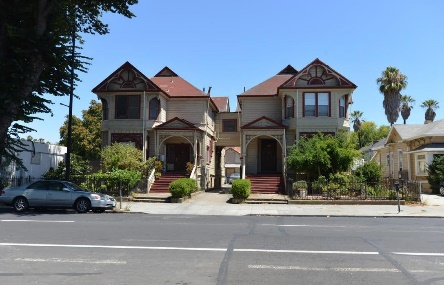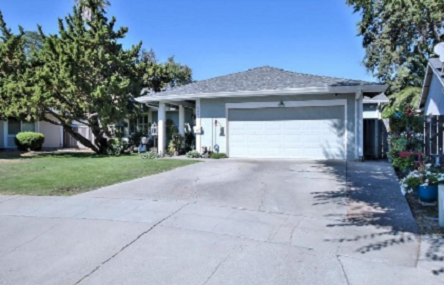


Visual similarity:
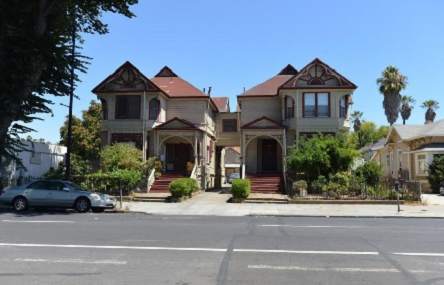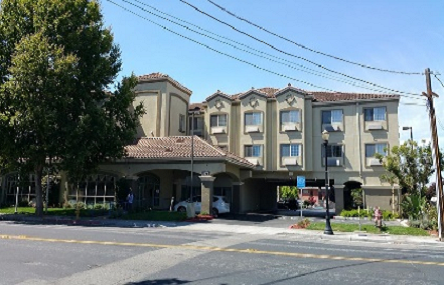


For semantic similarity, usually it's an image classification problem, and can be effectively resolved with the popular image perception models like GoogLeNet or ResNet.

For visual similarity, there have been many techniques applied across the history:

1. SIFT, SURF, color histogram
Conventional feature descriptors can be used to compare image similarity. SIFT feature descriptor is invariant to uniform scaling, orientation, and illumination changes, and makes it useful for applications like finding a small image within a larger image.

2. pHash
This mathematical algorithm analyzes an image's content and represents it using a 64-bit number fingerprint. Two images’ pHash values are close to one another if the images’ content features are similar.

3. Image embedding with convolutional neural networks (convnet)
Finding the image embedding from the convnet; usually it’s the first linear layer after the convolution and pooling.
4. Siamese Network or Deep Ranking
A more thorough deep learning solution, but the result model depends heavily on the training data, and may lose generality.


## Solution with Analytics Zoo
To recommend houses based on image similarity, we first compare the query image of the selected listing photo
with the title images of candidate houses. Next, a similarity score for each candidate house is generated.
Only the top results are chosen based on ranking. By working with domain experts, the following measure
for calculating similarity for house images was developed.
```
For each image in the candidates, compare with query image {
 
     category score: scene of the image (Bedroom, Kitchen, exterior etc.)
      
     tag score: Compare important semantic tags. (ranch style, hardwood-floor etc.)
 
     visual score: Visually similarity score, higher is better
      
     final Score = class score (decisive)   //~1
                 + tag score (significant)  //~0.3
                 + visual score             //[0,1]
}
```
In this project, both semantic similarity and visual similarity were used. BigDL provides a rich set of functionalities to support training or inference image similarity models, including:

-  Providing helpful image readers and transformers based on Apache Spark and OpenCV* for parallel image preprocessing.
-  Natively supporting the Spark ML* Estimator/Transformer interface, so that users can perform deep learning training and inference within the Spark ML pipeline.
-  Providing convenient model fine-tuning support and a flexible programming interface for model adjustment. Users can load pretrained Caffe*, Torch* or TensorFlow* models into BigDL for fine-tuning or inference.


## Semantic similarity Model

For semantic similarity, multiple image classification models are used to category the image scene and add import semantic tags to image. Each tag (E.g. House style, number of stories) normally would require an indivisual multiClass classification model.

Here we train a scene classification model as a sample. We use training data from http://places2.csail.mit.edu/explore.html to train a multiclassification model, related categories are 
bathroom, bedroom, house, kitchen.

We will fine tune the model from a pretrained Inception on Places2 dataset. 

1. Download the model from https://github.com/CSAILVision/places365
more concretely GoogLeNet-places365: [deploy](https://github.com/CSAILVision/places365/blob/master/deploy_googlenet_places365.prototxt) [weights](http://places2.csail.mit.edu/models_places365/googlenet_places365.caffemodel)

2. Download the images from http://places2.csail.mit.edu/download.html 
more concretely [Small images (256 * 256)](http://data.csail.mit.edu/places/places365/train_256_places365standard.tar) Train images. 24GB. MD5: 53ca1c756c3d1e7809517cc47c5561c5.
Unpack the downloaded tar file and copy the bathroom, bedroom, dining_room, house, kitchen, living_room folders to a new folder named imageClassification, in which each category resides in its own sub foler. E.g. bedroom images will be in the path ".../imageClassification/bedroom".
    
3. Start training with the following code:



In [1]:
import re

from bigdl.nn.criterion import CrossEntropyCriterion
from pyspark import SparkConf
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType, StringType

from zoo.common.nncontext import *
from zoo.feature.image import *
from zoo.pipeline.api.keras.layers import Dense, Input, Flatten
from zoo.pipeline.api.net import *
from zoo.pipeline.nnframes import *

sparkConf = SparkConf().setAppName("ImageSimilarityExample")
sc = init_nncontext(sparkConf)

creating: createDefault
creating: createSGD
creating: createSeqToTensor
creating: createSeqToTensor
creating: createSeqToTensor
creating: createSeqToTensor
creating: createSeqToTensor


In [2]:
image_path = "/tmp/images/imageClassification/*/*"
imageDF = NNImageReader.readImages(image_path, sc, 24).sample(False, 0.5)

def getLabel(path):
    if "bathroom" in path: label = 1.0
    elif "bedroom" in path: label = 2.0
    elif "house" in path: label = 3.0
    else: label = 4.0
    return label

getLabelUDF = udf(lambda row: getLabel(row[0]), DoubleType())
labelDF = imageDF.withColumn("label", getLabelUDF(col('image')))
(trainingDF, validationDF) = labelDF.randomSplit([0.8, 0.2])
trainingDF.cache()
print("training data distribution:")
trainingDF.groupBy("label").count().show()

training data distribution:
+-----+-----+
|label|count|
+-----+-----+
|  1.0| 2056|
|  4.0| 2044|
|  3.0| 2031|
|  2.0| 1962|
+-----+-----+



In [3]:

model_def_path = "/tmp/images/googlenet_places365/deploy.prototxt"
model_weight_path = "/tmp/images/googlenet_places365/googlenet_places365.caffemodel"

# load pretrained caffe model
preTrained_model = Net.load_caffe(model_def_path, model_weight_path)

# create a new model by remove layers after pool5/drop_7x7_s1
part_model = preTrained_model.new_graph(["pool5/drop_7x7_s1"])

# optionally freeze layers from input to pool4/3x3_s2 inclusive
# model.freeze_up_to(["pool4/3x3_s2"])

In [4]:
from bigdl.nn.layer import Sequential, Linear, View, LogSoftMax
from bigdl.nn.criterion import CrossEntropyCriterion

# add a new linear layer with numClass outputs, in our example, it's 6.
scene_network = Sequential().add(part_model).add(View([1024])).add(Linear(1024, 6)).add(LogSoftMax())

transformer = ChainedPreprocessing(
    [RowToImageFeature(), ImageResize(256, 256), ImageCenterCrop(224, 224),
     ImageChannelNormalize(123.0, 117.0, 104.0), ImageMatToTensor(), ImageFeatureToTensor()])

classifier = NNClassifier(scene_network, CrossEntropyCriterion(), transformer) \
    .setLearningRate(0.001).setLearningRateDecay(1e-3) \
    .setBatchSize(20).setMaxEpoch(2).setFeaturesCol("image") \
    .setCachingSample(False)

# train the model, training progress is available in Jupyter notebook console.
scene_classification_model = classifier.fit(trainingDF)
print("Finished training")

creating: createSequential
creating: createView
creating: createLinear
creating: createLogSoftMax
creating: createRowToImageFeature
creating: createImageResize
creating: createImageCenterCrop
creating: createImageChannelNormalize
creating: createImageMatToTensor
creating: createImageFeatureToTensor
creating: createChainedPreprocessing
creating: createCrossEntropyCriterion
creating: createScalarToTensor
creating: createFeatureLabelPreprocessing
creating: createNNClassifier
creating: createToTuple
creating: createChainedPreprocessing
creating: createTensorToSample
creating: createChainedPreprocessing
Finished training


In [5]:
# evaluate the model
print("Start evaluation:")
predictionDF = scene_classification_model.transform(validationDF).cache()
predictionDF.sample(False, 0.01).show()

correct = predictionDF.filter("label=prediction").count()
overall = predictionDF.count()
accuracy = correct * 1.0 / overall
predictionDF.unpersist()
trainingDF.unpersist()
print("Accuracy = %g " % accuracy)

Start evaluation:
+--------------------+-----+----------+
|               image|label|prediction|
+--------------------+-----+----------+
|[file:/tmp/images...|  2.0|       2.0|
|[file:/tmp/images...|  2.0|       2.0|
|[file:/tmp/images...|  2.0|       2.0|
|[file:/tmp/images...|  2.0|       2.0|
|[file:/tmp/images...|  3.0|       3.0|
|[file:/tmp/images...|  3.0|       3.0|
|[file:/tmp/images...|  3.0|       3.0|
|[file:/tmp/images...|  3.0|       3.0|
|[file:/tmp/images...|  1.0|       1.0|
|[file:/tmp/images...|  1.0|       1.0|
|[file:/tmp/images...|  1.0|       1.0|
|[file:/tmp/images...|  1.0|       1.0|
|[file:/tmp/images...|  1.0|       1.0|
|[file:/tmp/images...|  4.0|       4.0|
+--------------------+-----+----------+

Accuracy = 0.974333 


## Visual Similarity Model

We first built an evaluation dataset to choose the best options for image similarity computation. In the evaluation dataset, each record contains three images.

```Triplet (query image, positive image, negative image)```

where positive image is more similar to the query image than the negative image


In the four methods listed above for computing visually similarity, Siamese Network or Deep Ranking appear to be more precise, but due to the lack of training data to support meaningful models, the results were inconclusive. With the help of the evaluation dataset we tried the other three methods, and both SIFT and pHash produced unreasonable results. We suspect that was because both of them cannot represent the essential characteristics of real estate images.

Using image embedding from the pretrained deep learning models on the Places dataset, the expected precision accuracy level was achieved:

Network | Embedding  | Precision
------- | -------- | --------
Deepbit*| 1024 binary |80%
GoogLeNet*|1024 floats |84%
VGG-16 | 25088 floats | 93%

Similarity (m1, m2) = cosine (embedding (m1), embedding (m2)).

After L2 normalization, cosine similarity can be computed very efficiently. While VGG-16 embedding has a clear advantage, we also tried the SVM model trained from the evaluation dataset to assign different weight to each of the embedding features, but this only gives limited improvement, and we are concerned that the SVM model may not be general enough to cover the real-world images.

Next we demo how to extract image embedding with a pretrained VGG network on places2 dataset.

A pretrained VGG network can be downloaded from https://github.com/CSAILVision/places365, more concretely:
VGG16-places365: [deploy](https://github.com/CSAILVision/places365/blob/master/deploy_vgg16_places365.prototxt) [weights](http://places2.csail.mit.edu/models_places365/vgg16_hybrid1365.caffemodel)

 

In [6]:

vgg_def_path = "/tmp/images/vgg_16_places365/deploy.prototxt"
vgg_weight_path = "/tmp/images/vgg_16_places365/vgg16_places365.caffemodel"

transformer = ChainedPreprocessing(
    [RowToImageFeature(), ImageResize(256, 256), ImageCenterCrop(224, 224),
     ImageChannelNormalize(123.0, 117.0, 104.0), ImageMatToTensor(), ImageFeatureToTensor()])

full_model = Net.load_caffe(vgg_def_path, vgg_weight_path)

creating: createRowToImageFeature
creating: createImageResize
creating: createImageCenterCrop
creating: createImageChannelNormalize
creating: createImageMatToTensor
creating: createImageFeatureToTensor
creating: createChainedPreprocessing


In [ ]:
from bigdl.nn.layer import Sequential, View, Normalize

# create a new model by removing layers after pool5
model = full_model.new_graph(["pool5"])
# generates a vector of dimension 25088 for each image
vggModel = Sequential().add(model).add(View([25088])).add(Normalize(2.0))

embeddingModel = NNModel(vggModel, transformer).setFeaturesCol("image")
embeddingModel.transform(imageDF.limit(10)).show()

creating: createSequential
creating: createView
creating: createNormalize
creating: createTensorToSample
creating: createChainedPreprocessing
creating: createNNModel
+--------------------+--------------------+
|               image|          prediction|
+--------------------+--------------------+
|[file:/tmp/images...|[0.0, 0.0, 0.0, 0...|
|[file:/tmp/images...|[0.0, 0.0, 0.0, 0...|
|[file:/tmp/images...|[0.0, 0.0, 0.0, 0...|
|[file:/tmp/images...|[0.0, 0.0, 0.0, 0...|
|[file:/tmp/images...|[0.0, 0.0, 0.0048...|
|[file:/tmp/images...|[0.0, 0.0, 0.0, 0...|
|[file:/tmp/images...|[0.0, 0.0, 0.0, 0...|
|[file:/tmp/images...|[0.0, 0.0, 0.0, 0...|
|[file:/tmp/images...|[0.0, 0.0, 0.0, 0...|
|[file:/tmp/images...|[0.0, 0.0, 0.0, 0...|
+--------------------+--------------------+



Qury for similar images:

After getting the sample scene classification model and VGG model, we can process all the images to extract category info and embedding. The pre-calculated information helps for the online API query and meet the low latecy requirement.



In [ ]:
image_path = "/tmp/images/imageClassification/house/*"
imageDF = NNImageReader.readImages(image_path, sc, 24).sample(False, 0.4)

pathDF = with_origin_column(imageDF)
sceneDF = scene_classification_model.setBatchSize(20).setPredictionCol("sceneClassification").transform(pathDF)
embeddingDF = embeddingModel.setBatchSize(20).setPredictionCol("embedding").transform(sceneDF)
# save data in a dict, where key is the path of the image, value are category and embedding
imageDict = embeddingDF.select("origin", "sceneClassification", "embedding").rdd \
    .map(lambda r: (r[0], (r[1], r[2]))) \
    .collectAsMap()
print(str(len(imageDict)) + " images cached in imageDict")

We just picked a random house image as the query image, E.g. house/00000099.jpg
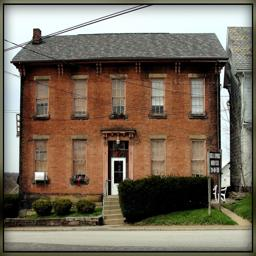

In [ ]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf, struct, col
import numpy as np
    
query_origin = "file:/tmp/images/imageClassification/house/00000001.jpg"
query_record = imageDict[query_origin]

query_classification = query_record[0]
query_embedding = query_record[1]

def get_score(x):
    candidate_classification = x[0]
    candidate_embedding = x[1]
    classScore = 1.0 if query_classification == candidate_classification else 0.0
    visualScore = np.dot(query_embedding, candidate_embedding)
    return classScore + visualScore

score_dict = {k: get_score(v) for k, v in imageDict.items()}

# select the top 3 most similar images
top_3 = nlargest(3, imageDict.iteritems(), itemgetter(1))


Besides the query image itself, the other two most similar images are 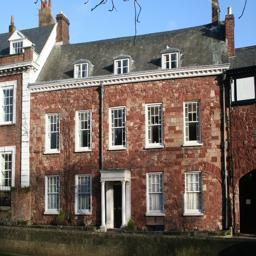
and 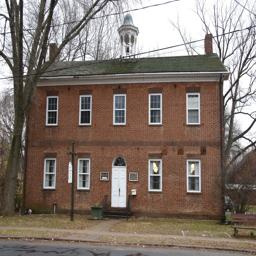

## Production deployment
In production, the project can be separated into three parts:

1. Model training (offline)
The model training mainly refers to the semantic models (GoogLeNet v1 fine-tuned on the Place dataset) and also finding the proper embedding for visual similarity calculation. Retraining may happen periodically depending on model performance or requirement changes.
2. Image inference (online)
With the trained semantic models (GoogLeNet v1) in the first step and the pretrained VGG-16, we can convert the images to tags and embeddings, and save the results in a key-value cache. (Apache HBase* or SQL* can also be used).
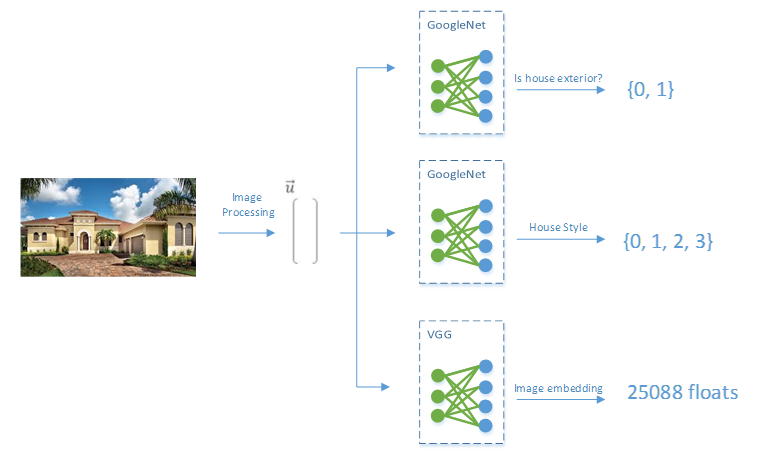
All the existing images and new images need to go through the inference above and converted into a table structure, as shown:
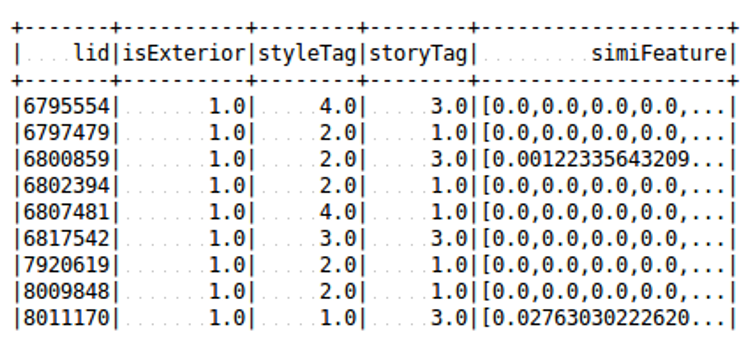
The inference process can happen periodically (for example, one day) or triggered by a new image upload from a real estate listing entry. Each production image only needs to go through the inference process once. With the indexed image tagging and similarity feature, fast query performance is supported in a high concurrency environment.
3. API serving for query (online)
The house recommendation system exposes a service API to its upstream users. Each query sends a query image and candidate images as parameters. With the indexed image information shown in the table above, we can quickly finish the one-versus- many query. For cosine similarity, processing is very efficient and scalable.

## Demo

We provided two examples from the online website:

Example 1
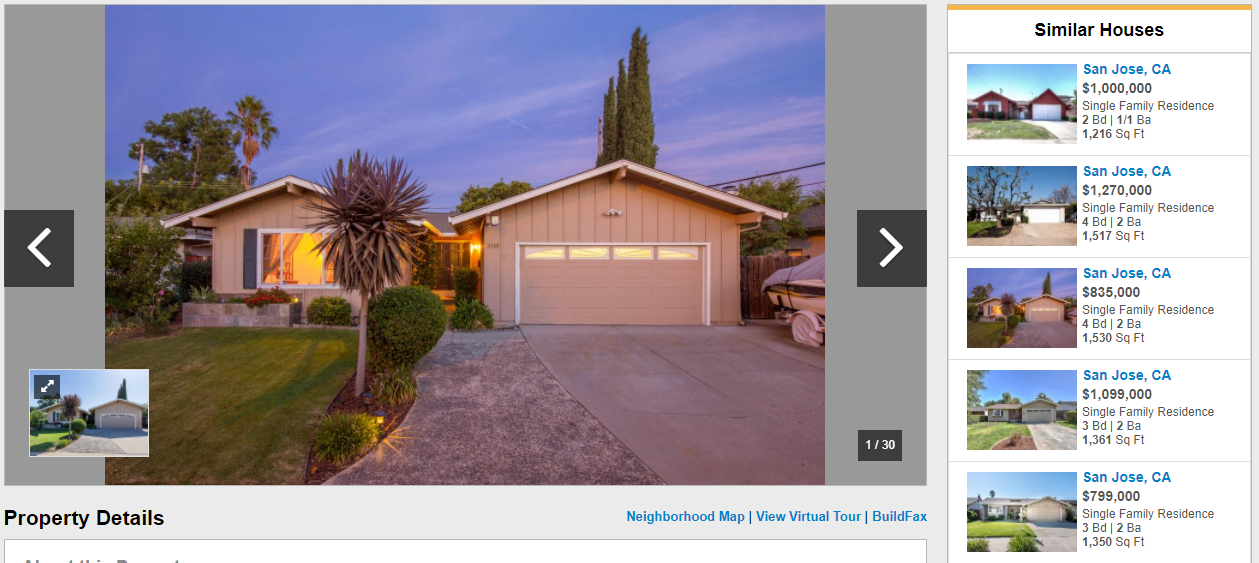
Example 2
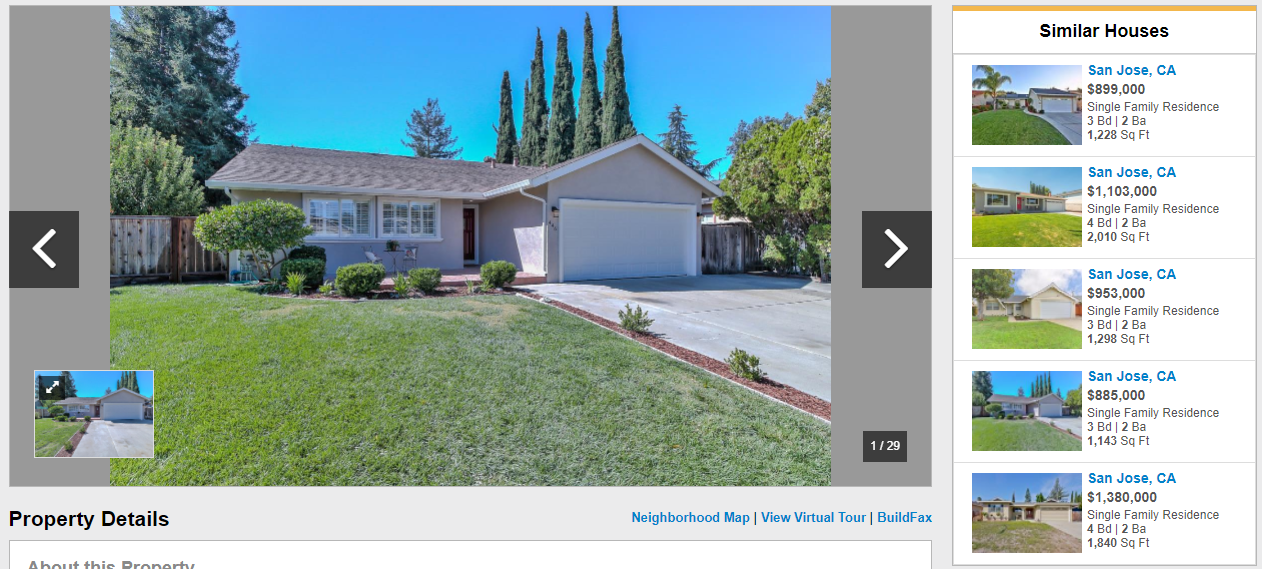


## Summary

This notebook described how to use Deep Learning neural networks to extract important semantic tags and calculate the image similarity utilizing Intel Analytics Zoo. One deep learning classification models was fine-tuned from pretrained Caffe models in order to extract the important semantic tags from real estate images. We further compared different visual similarity computation methods and found image embedding from VGG to be the most helpful inference model in our case. As an end-to-end industry example, we demonstrated how to leverage deep learning with Analytics Zoo to enable greater deep learning-based image recognition innovation for the industry.